In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV

In [3]:
plt.rcParams['figure.figsize'] = [10, 5]

In [8]:
df = pd.read_csv('data/Android_Malware.csv', low_memory = False)
df

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,172.217.6.202-10.42.0.211-443-50004-6,10.42.0.211,50004,172.217.6.202,443.0,6.0,13/06/2017 11:52:39,37027,1,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
1,1,172.217.6.202-10.42.0.211-443-35455-6,10.42.0.211,35455,172.217.6.202,443.0,6.0,13/06/2017 11:52:39,36653,1,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
2,2,131.253.61.68-10.42.0.211-443-51775-6,10.42.0.211,51775,131.253.61.68,443.0,6.0,13/06/2017 11:52:42,534099,8,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
3,3,131.253.61.68-10.42.0.211-443-51775-6,10.42.0.211,51775,131.253.61.68,443.0,6.0,13/06/2017 11:52:43,9309,3,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
4,4,131.253.61.68-10.42.0.211-443-51776-6,10.42.0.211,51776,131.253.61.68,443.0,6.0,13/06/2017 11:52:42,19890496,8,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355625,405,172.217.7.14-10.42.0.211-80-38405-6,172.217.7.14,80,10.42.0.211,38405.0,6.0,17/06/2017 01:29:11,126711,1,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
355626,406,10.42.0.211-10.42.0.1-7632-53-17,10.42.0.211,7632,10.42.0.1,53.0,17.0,17/06/2017 01:30:33,48012,1,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
355627,407,10.42.0.211-104.192.110.245-45970-443-6,10.42.0.211,45970,104.192.110.245,443.0,6.0,17/06/2017 01:29:45,20028018,11,...,20.0,367528.0,0.0,367528.0,367528.0,19660490.0,0.0,19660490.0,19660490.0,Benign
355628,408,10.42.0.211-10.42.0.1-51982-53-17,10.42.0.211,51982,10.42.0.1,53.0,17.0,17/06/2017 01:29:45,347926,1,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


### Dzielenie na train/test/ walidacje oraz analiza danych

In [9]:
X_train, X_test_tmp, y_train, y_test_tmp = train_test_split(
    df[df.columns.values[:-1]],
    df[df.columns.values[-1]],
    test_size=0.4, random_state=213)

In [10]:
X_test, X_validation, y_test, y_validation = train_test_split(
    X_test_tmp,
    y_test_tmp,
    test_size=0.5, random_state=7)

In [11]:
df = X_train 
df["Label"] = y_train

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213378 entries, 60634 to 183595
Data columns (total 86 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    213378 non-null  int64  
 1   Flow ID                       213378 non-null  object 
 2    Source IP                    213378 non-null  object 
 3    Source Port                  213378 non-null  int64  
 4    Destination IP               213378 non-null  object 
 5    Destination Port             213378 non-null  float64
 6    Protocol                     213378 non-null  float64
 7    Timestamp                    213378 non-null  object 
 8    Flow Duration                213378 non-null  int64  
 9    Total Fwd Packets            213378 non-null  int64  
 10   Total Backward Packets       213378 non-null  int64  
 11  Total Length of Fwd Packets   213378 non-null  float64
 12   Total Length of Bwd Packets  213378 non

jak wygladaja najpopularniejsze wartosci w kazdej z kolumn

In [13]:
for col in df.columns:
    print(f"Top 10 most common values in {col}:")
    print(df[col].value_counts().nlargest(10))
    print()

Top 10 most common values in Unnamed: 0:
130    104
70     102
171    101
5      101
114    100
224    100
122    100
255    100
304    100
115     99
Name: Unnamed: 0, dtype: int64

Top 10 most common values in Flow ID:
8.0.6.4-8.6.0.1-0-0-0                        1278
224.0.0.251-10.42.0.1-5353-5353-17             92
224.0.0.251-10.42.0.211-5353-5353-17           69
10.42.0.255-10.42.0.1-8612-8612-17             65
10.42.0.255-10.42.0.1-8610-8612-17             62
255.255.255.255-0.0.0.0-67-68-17               48
224.0.0.251-10.42.0.151-5353-5353-17           41
157.56.52.45-10.42.0.211-40024-60774-17        36
157.55.130.155-10.42.0.211-40008-60774-17      36
157.55.235.173-10.42.0.211-40024-60774-17      35
Name: Flow ID, dtype: int64

Top 10 most common values in  Source IP:
10.42.0.211        107241
10.42.0.151         71968
10.42.0.42          10870
8.6.0.1              1278
10.42.0.1            1098
202.77.129.150        578
119.146.74.48         527
192.229.173.173       242
6

Name:  ACK Flag Count, dtype: int64

Top 10 most common values in  URG Flag Count:
0.0    170008
1.0     43370
Name:  URG Flag Count, dtype: int64

Top 10 most common values in  CWE Flag Count:
0            211478
0.0            1899
SCAREWARE         1
Name:  CWE Flag Count, dtype: int64

Top 10 most common values in  ECE Flag Count:
0.0    213377
Name:  ECE Flag Count, dtype: int64

Top 10 most common values in  Down/Up Ratio:
0.0    92495
1.0    91180
0      12327
1      10132
2.0     4652
3.0     1200
2        689
4.0      249
3        220
5.0       76
Name:  Down/Up Ratio, dtype: int64

Top 10 most common values in  Average Packet Size:
0.000000      89462
31.000000      3775
54.000000      2115
10.333333      1430
55.000000      1373
46.500000      1268
100.000000     1159
72.000000      1085
123.714286      946
7.750000        900
Name:  Average Packet Size, dtype: int64

Top 10 most common values in  Avg Fwd Segment Size:
0.0     92014
31.0     7063
36.0     4995
32.0     3867


ilosc unikalnych wartosci w kazdej z kolumn

In [14]:
with pd.option_context('display.max_rows', None):
    print(df.nunique(dropna=False))

Unnamed: 0                       11016
Flow ID                         136843
 Source IP                        2152
 Source Port                     44516
 Destination IP                   4233
 Destination Port                14374
 Protocol                            5
 Timestamp                       59471
 Flow Duration                  168360
 Total Fwd Packets                 518
 Total Backward Packets            772
Total Length of Fwd Packets       7895
 Total Length of Bwd Packets     17724
 Fwd Packet Length Max            1397
 Fwd Packet Length Min             177
 Fwd Packet Length Mean          24595
 Fwd Packet Length Std           31476
Bwd Packet Length Max             1240
 Bwd Packet Length Min             446
 Bwd Packet Length Mean          26458
 Bwd Packet Length Std           30165
Flow Bytes/s                    115475
 Flow Packets/s                 176661
 Flow IAT Mean                  171639
 Flow IAT Std                    99079
 Flow IAT Max            

rozklad przewidywanej cechy

<AxesSubplot:>

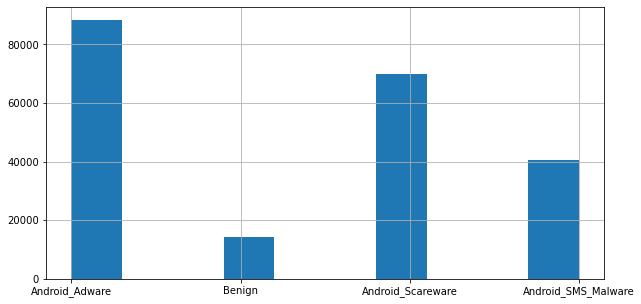

In [15]:
df.iloc[:, -1].hist()

"Adware jest niechcianym oprogramowaniem służącym do wyświetlania reklam na Twoim ekranie". Adware generuje przychody dla swoich twórców dzięki automatycznemu wyświetlaniu internetowych reklam w interfejsie użytkownika danej aplikacji lub w formie okienek wyskakujących podczas procesu instalacji.

Scareware is a type of malware attack that claims to have detected a virus or other issue on a device and directs the user to download or buy malicious software to resolve the problem. Generally speaking, scareware is the gateway to a more intricate cyberattack and not an attack in and of itself.

benign - having no harmful influence or effect

Wszystkie NA są skumulowane we wierszach które można policzyć na palcach jedner ręki można je usunąć

In [16]:
df = df.dropna()

Usunięcie kolumn które mają tylko jedną wartość

In [17]:
col_to_drop = df.columns[df.nunique() <= 1]
df = df.drop(columns = col_to_drop)

Usunięcie kolumn ID, i dwóch kolumn w których są same zera ale zapisane na różne sposoby (int, str, float)

Ta kolumna ma wartości które są int i float, zrzutujemy je na int

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213376 entries, 60634 to 183595
Data columns (total 76 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    213376 non-null  int64  
 1   Flow ID                       213376 non-null  object 
 2    Source IP                    213376 non-null  object 
 3    Source Port                  213376 non-null  int64  
 4    Destination IP               213376 non-null  object 
 5    Destination Port             213376 non-null  float64
 6    Protocol                     213376 non-null  float64
 7    Timestamp                    213376 non-null  object 
 8    Flow Duration                213376 non-null  int64  
 9    Total Fwd Packets            213376 non-null  int64  
 10   Total Backward Packets       213376 non-null  int64  
 11  Total Length of Fwd Packets   213376 non-null  float64
 12   Total Length of Bwd Packets  213376 non

### Usuwanie skorelowanych kolumn oraz transformacja danych

In [19]:
def select_correlated_columns_to_remove(df, corr_treshold):
    cor_lis = []
    cor = df.corr(method="spearman")
    for i, _ in enumerate(cor.columns):
        for j, col_name_to_drop in enumerate(cor.columns):
            if i < j and (abs(cor.iloc[i,j]) > corr_treshold or math.isnan(cor.iloc[i,j])):
                cor_lis.append(col_name_to_drop)
    return cor_lis

Użyliśmy na początku korelacji spearmana, żeby zostawić jak najmniej kolumn i sprawdzić, które z nich są wartościowe. Po policzeniu Auc odrzuciliśmy prawie wszystkie oryginalne kolumny. Zatem nie wracaliśmy już do tego punktu.

In [20]:
cor_lis = select_correlated_columns_to_remove(df, 0.95)
df=df.drop(cor_lis,axis =1 )

In [21]:
def transform_data(X,y):
    df = X
    df["Label"] = y
    df = df.dropna()
    df = df.drop(columns = col_to_drop)
    df = df.drop(columns = ["Unnamed: 0", "Flow ID", " CWE Flag Count", "Fwd Avg Bytes/Bulk",' Protocol',' Down/Up Ratio'])
    
    ip = list(df[' Source IP'])
    ip = [[int(ip[i].split('.')[j]) for j in range(len(ip[i].split('.')))] for i in range(len(ip))]
    ip = pd.DataFrame(ip).fillna(0)
    ip.columns = ['Source IP1','Source IP2',"Source IP3","Source IP4"]
    ip2 = list(df[' Destination IP'])
    ip2 = [[int(ip2[i].split('.')[j]) for j in range(len(ip2[i].split('.')))] for i in range(len(ip2))]
    ip2 = pd.DataFrame(ip2).fillna(0)
    ip2.columns = ['Destination IP1','Destination IP2',"Destination IP3","Destination IP4"]
    ip = pd.concat([ip,ip2], axis = 1)
    df = pd.concat([df.reset_index(),ip],axis = 1).drop('index', axis = 1)
    
    mapping_dict = {"Benign": 0,
                "Android_Scareware":1,
                "Android_Adware": 2,
                "Android_SMS_Malware":3}
    
    df["Label"] = pd.Series(df["Label"]).map(mapping_dict)
 
    df = df.drop(columns = cor_lis,errors='ignore')
    return df.drop("Label", axis=1), df["Label"]

In [22]:
X_test, y_test = transform_data(X_test, y_test)
X_train, y_train = transform_data(X_train, y_train)

### Wybór kolumn po tranformacji danych

In [23]:
""""
Sposób w jaki liczyliśmy auc

from feature_engine.selection import SelectBySingleFeaturePerformance

sel1 = SelectBySingleFeaturePerformance(
    estimator=RandomForestClassifier(random_state=1),
    scoring='roc_auc'
)

for i in range(4):
    Y = np.select([y_train == i], [1], 0 )
    sel1.fit(X_train, Y)
    print(sel1.feature_performance_)
"""


'"\nSposób w jaki liczyliśmy auc\n\nfrom feature_engine.selection import SelectBySingleFeaturePerformance\n\nsel1 = SelectBySingleFeaturePerformance(\n    estimator=RandomForestClassifier(random_state=1),\n    scoring=\'roc_auc\'\n)\n\nfor i in range(4):\n    Y = np.select([y_train == i], [1], 0 )\n    sel1.fit(X_train, Y)\n    print(sel1.feature_performance_)\n'

Nie ma sensu za każdym razem liczyć auc, więc wczytamy już policzone. 
Każde auc odpowiada za wykrywanie 1 kategorii więc jest ich łącznie 4.

In [24]:
auc0={' Source Port': 0.6667803137571054,
 ' Destination Port': 0.5280530163444412,
 ' Flow Duration': 0.5432468532109304,
 ' Total Fwd Packets': 0.5115232835638613,
 ' Total Backward Packets': 0.5257881750154091,
 'Total Length of Fwd Packets': 0.564206596036872,
 ' Total Length of Bwd Packets': 0.5609472971943124,
 ' Fwd Packet Length Min': 0.5288376538496439,
 ' Fwd Packet Length Std': 0.5410624009741203,
 ' Bwd Packet Length Min': 0.5310371093541425,
 ' Bwd Packet Length Std': 0.5376187852377542,
 'Flow Bytes/s': 0.5226595986307652,
 ' Flow Packets/s': 0.5341000756469306,
 ' Flow IAT Std': 0.5098433977150534,
 ' Flow IAT Min': 0.5419213925068221,
 'Fwd IAT Total': 0.5396089111679344,
 ' Fwd IAT Std': 0.5107185905594186,
 ' Fwd IAT Min': 0.549299241535541,
 'Bwd IAT Total': 0.5101626024184551,
 ' Bwd IAT Std': 0.5073457412803558,
 'Fwd PSH Flags': 0.4995634750962859,
 ' Fwd Header Length': 0.5293550369946379,
 ' Bwd Packets/s': 0.523087600852063,
 'FIN Flag Count': 0.49969180699706683,
 ' PSH Flag Count': 0.5056831548783184,
 ' ACK Flag Count': 0.5075828796322425,
 ' URG Flag Count': 0.5025464541539769,
 'Init_Win_bytes_forward': 0.5686777003883696,
 ' Init_Win_bytes_backward': 0.5744043850502205,
 ' act_data_pkt_fwd': 0.5155759304794502,
 ' min_seg_size_forward': 0.5082642067158343,
 'Active Mean': 0.5039074595954259,
 ' Active Std': 0.5008584278213167,
 ' Idle Std': 0.5016072510651556,
 'Source IP1': 0.5208522632633458,
 'Source IP2': 0.5224823089204553,
 'Source IP3': 0.522061468243979,
 'Source IP4': 0.5704274681398592,
 'Destination IP1': 0.5834675438830063,
 'Destination IP2': 0.6053260099365425,
 'Destination IP3': 0.6391564449566961,
 'Destination IP4': 0.6331360322937867}

auc1={' Source Port': 0.6095152607547952,
 ' Destination Port': 0.5260450208036361,
 ' Flow Duration': 0.5281273614448136,
 ' Total Fwd Packets': 0.5108599238826574,
 ' Total Backward Packets': 0.5179758046764285,
 'Total Length of Fwd Packets': 0.545840953226306,
 ' Total Length of Bwd Packets': 0.559587460354607,
 ' Fwd Packet Length Min': 0.5150061953828514,
 ' Fwd Packet Length Std': 0.5330914556927385,
 ' Bwd Packet Length Min': 0.5222729790837767,
 ' Bwd Packet Length Std': 0.5393663579909972,
 'Flow Bytes/s': 0.5141840016015934,
 ' Flow Packets/s': 0.5234415339130424,
 ' Flow IAT Std': 0.5073244426784005,
 ' Flow IAT Min': 0.5254465601232302,
 'Fwd IAT Total': 0.5254558091371572,
 ' Fwd IAT Std': 0.5068278697367655,
 ' Fwd IAT Min': 0.5280507427475585,
 'Bwd IAT Total': 0.5039745923406389,
 ' Bwd IAT Std': 0.5042883451291047,
 'Fwd PSH Flags': 0.5010867151639863,
 ' Fwd Header Length': 0.5231815422844631,
 ' Bwd Packets/s': 0.5163463778158034,
 'FIN Flag Count': 0.5012267692229343,
 ' PSH Flag Count': 0.501299177193454,
 ' ACK Flag Count': 0.5003763616250868,
 ' URG Flag Count': 0.5057836854464591,
 'Init_Win_bytes_forward': 0.5445225899283014,
 ' Init_Win_bytes_backward': 0.5488982957554105,
 ' act_data_pkt_fwd': 0.5131342031079205,
 ' min_seg_size_forward': 0.5080447640893865,
 'Active Mean': 0.4997263815266238,
 ' Active Std': 0.5000967069366542,
 ' Idle Std': 0.50039666411773,
 'Source IP1': 0.5120834867732361,
 'Source IP2': 0.513812621724962,
 'Source IP3': 0.5176831109568006,
 'Source IP4': 0.590142209910279,
 'Destination IP1': 0.5669543381574059,
 'Destination IP2': 0.5847780097124761,
 'Destination IP3': 0.61243985785373,
 'Destination IP4': 0.6058817694807083}

auc2={' Source Port': 0.619494360969236,

 ' Destination Port': 0.5522096964193727,
 ' Flow Duration': 0.565340184513613,
 ' Total Fwd Packets': 0.5288163459577616,
 ' Total Backward Packets': 0.5432622240389144,
 'Total Length of Fwd Packets': 0.5797146557503599,
 ' Total Length of Bwd Packets': 0.589504149307628,
 ' Fwd Packet Length Min': 0.5281609705719504,
 ' Fwd Packet Length Std': 0.5622176644585165,
 ' Bwd Packet Length Min': 0.5359076230719914,
 ' Bwd Packet Length Std': 0.5621001539754732,
 'Flow Bytes/s': 0.5384421326083486,
 ' Flow Packets/s': 0.5587014714464367,
 ' Flow IAT Std': 0.5355029736402083,
 ' Flow IAT Min': 0.5572710324588441,
 'Fwd IAT Total': 0.5552154921669692,
 ' Fwd IAT Std': 0.525457563232787,
 ' Fwd IAT Min': 0.557227927917605,
 'Bwd IAT Total': 0.5274787185312164,
 ' Bwd IAT Std': 0.5199107052302893,
 'Fwd PSH Flags': 0.5110209992354248,
 ' Fwd Header Length': 0.5649256821571141,
 ' Bwd Packets/s': 0.548567384472877,
 'FIN Flag Count': 0.4996152994949028,
 ' PSH Flag Count': 0.5064995958124713,
 ' ACK Flag Count': 0.5097289292362083,
 ' URG Flag Count': 0.5069323779637565,
 'Init_Win_bytes_forward': 0.5734484114927324,
 ' Init_Win_bytes_backward': 0.5742372376657341,
 ' act_data_pkt_fwd': 0.5250498204674048,
 ' min_seg_size_forward': 0.5428487384051487,
 'Active Mean': 0.5085359523478155,
 ' Active Std': 0.5018885551873704,
 ' Idle Std': 0.5026271133955946,
 'Source IP1': 0.5093481226733437,
 'Source IP2': 0.5127355525526736,
 'Source IP3': 0.5197810657086236,
 'Source IP4': 0.6292940726601796,
 'Destination IP1': 0.6000708569101265,
 'Destination IP2': 0.6179593909811868,
 'Destination IP3': 0.6542533934055511,
 'Destination IP4': 0.6413952745660961}

auc3={' Source Port': 0.6379991311189014,
 ' Destination Port': 0.5563665831240362,
 ' Flow Duration': 0.5529182319576855,
 ' Total Fwd Packets': 0.5345564020394712,
 ' Total Backward Packets': 0.5387853249046745,
 'Total Length of Fwd Packets': 0.5813068547666688,
 ' Total Length of Bwd Packets': 0.5878820742615405,
 ' Fwd Packet Length Min': 0.5340162772250147,
 ' Fwd Packet Length Std': 0.5628073596857487,
 ' Bwd Packet Length Min': 0.5443412553308494,
 ' Bwd Packet Length Std': 0.5596898660930836,
 'Flow Bytes/s': 0.5295650431784452,
 ' Flow Packets/s': 0.5470448477668078,
 ' Flow IAT Std': 0.5176486127553078,
 ' Flow IAT Min': 0.5521831300555938,
 'Fwd IAT Total': 0.5376555620659789,
 ' Fwd IAT Std': 0.512648110710675,
 ' Fwd IAT Min': 0.5392868522482441,
 'Bwd IAT Total': 0.5126170390994146,
 ' Bwd IAT Std': 0.5101814178361082,
 'Fwd PSH Flags': 0.5156249122280595,
 ' Fwd Header Length': 0.5775761891744442,
 ' Bwd Packets/s': 0.5442219795089852,
 'FIN Flag Count': 0.5018783188361402,
 ' PSH Flag Count': 0.5106739226613008,
 ' ACK Flag Count': 0.5116913166044152,
 ' URG Flag Count': 0.5036676099161546,
 'Init_Win_bytes_forward': 0.5839914725418078,
 ' Init_Win_bytes_backward': 0.5876287945470929,
 ' act_data_pkt_fwd': 0.5315391349473729,
 ' min_seg_size_forward': 0.5618074944179611,
 'Active Mean': 0.5017283625995507,
 ' Active Std': 0.5003691000455467,
 ' Idle Std': 0.5001430264872218,
 'Source IP1': 0.5192414158227315,
 'Source IP2': 0.5210207880736546,
 'Source IP3': 0.526187117293753,
 'Source IP4': 0.6431843405311595,
 'Destination IP1': 0.6118328221676916,
 'Destination IP2': 0.6287977678219656,
 'Destination IP3': 0.650626178105102,
 'Destination IP4': 0.6428527493983265}

Gdy policzymy sumę auc widzimy, że połowa zmiennych nie jest w stanie wykryć żadnej kategorii. 
Wykres przedstawia posortowane zmienne i ich średnie gini. 

<AxesSubplot:xlabel='0', ylabel='index'>

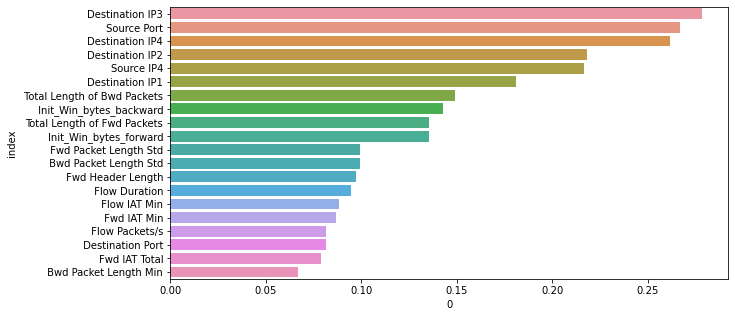

In [25]:
f = [2*(a0+a1+a2+a3)/4 -1 for a0,a1,a2,a3 in zip(list(auc0.values()),list(auc1.values()),list(auc2.values()),list(auc3.values())) ]
fcol = list(pd.DataFrame( f,list(auc1.keys())).sort_values(by = 0, ascending = False).index)
auc = pd.DataFrame( f,list(auc1.keys())).sort_values(by = 0, ascending = False).reset_index()
sns.barplot(data= auc[:20], y= 'index', x = 0)

Jak widzimy jedynie 10 pierwszych zmiennych ma stosunkowo spore gini. Jednak już po 6 zmiennej wynik mocno spada.

In [26]:
fcol = fcol[:6]+[' Destination Port','Source IP3','Source IP2','Source IP1']
fcol

['Destination IP3',
 ' Source Port',
 'Destination IP4',
 'Destination IP2',
 'Source IP4',
 'Destination IP1',
 ' Destination Port',
 'Source IP3',
 'Source IP2',
 'Source IP1']

Wzięliśmy 6 najbardziej predykcjnych zmiennych. Jak widzimy wszystkie przekazują nam informacje nie na temat samych pakietów co ich drogi wewnątrz sieci. Dorzuciliśmy Destination Port i resztę Source IP bo wydaje się, że powinny uzupełniać informacje na temat ich drogi. Może te zmienne samodzielnie są mało predykcyjne, lecz oryginalnie gdy się je połączy z resztą niosą pełną informacje na temat drogi pakietów.

### Hiperparametryzacja

In [27]:
X_learn, X_check, Y_learn, Y_check = train_test_split(
    X_train,
    y_train,
    test_size=0.2, random_state=7)

X_learn, X_val, Y_learn, Y_val = train_test_split(
    X_learn,
    Y_learn,
    test_size=0.2, random_state=7)


Będziemy dobierać parametr po parametrze. Zaczniemy od max_depth. Gdy zacieśnimy obszar gdzie może być maximum odpalimy grid searcha.

In [29]:
for i in range(2,20):
    model=XGBClassifier(random_state=1,
                        booster='gbtree', 
                        max_depth=i
                        )
    model.fit(X_learn[fcol], Y_learn)
    print(i,round(model.score(X_val[fcol],Y_val),3))

2 0.526
3 0.546


KeyboardInterrupt: 

Różnice wewnątrz różnych wartości learning_rate i n_estimators są niewielkie, więc zrobimy wykres tylko w zależności od wysokości drzew.

In [ ]:
sns.pointplot(x = list(range(2,20)), y = [0.524,0.542,0.56,0.584,0.617,0.648,0.674,0.695,
                                    0.708,0.724,0.736,0.739,0.746,0.746,0.749,0.749,0.75,0.75])

Po 16 już nie ma większej różnicy,a czas obliczeń mocno wzrasta, więc wybierzemy obszar od 14 do 16. Teraz sprawdzimy n_estimators dla max_depth = 15 jako środek przedziału.

In [ ]:
for i in range(1, 7):
    model=XGBClassifier(random_state=1,
                        n_estimators = 50*i,
                        booster='gbtree', 
                        max_depth=15,
                        tree_method = 'gpu_hist'
                        )
    model.fit(X_learn[fcol], Y_learn)
    print(50*i,round(model.score(X_val[fcol],Y_val),3))

Po 200 już nie dalej wyniki nie rosną. Zatem zatrzymamy się w przedziale od 100 do 200. Sprawdzimy jeszcze learning_rate przy 100 drzewach.

In [ ]:
for i in range(1, 10):
    model=XGBClassifier(random_state=1,
                        n_estimators = 100,
                        learning_rate = i/10,
                        booster='gbtree', 
                        max_depth=15,
                        tree_method = 'gpu_hist'
                        )
    model.fit(X_learn[fcol], Y_learn)
    print(i/10,round(model.score(X_val[fcol],Y_val),4))

Tutaj wybierzemy przedział od 0.6 do 0.8.

Odpalamy grid searcha na naszych przedziałach, żeby znaleźć najlepsze parametry. Trochę zmniejszyliśmy przedział n_estimators, żeby przyśpieszyć obliczenia.

In [ ]:
opt = XGBClassifier(random_state=1,
                        booster='gbtree', 
                        tree_method = 'gpu_hist'
                        )
max_depth = list(range(14,17))
learning_rate = [i/100 for i in range(65, 76,2)]
n_estimators = list(range(100,160,20))
param_grid = dict(max_depth=max_depth,learning_rate = learning_rate,n_estimators = n_estimators)

In [ ]:
#Skleimy z powrotem learna
X_learn= pd.concat([X_learn,X_val])
Y_learn = pd.concat([Y_learn,Y_val])

In [ ]:
#grid = GridSearchCV(estimator=opt, param_grid=param_grid, cv = 3, n_jobs=-1)
#grid_result = grid.fit(X_learn[fcol],Y_learn)

In [ ]:
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Użyjemy parametrów wyliczonych przez grida i sprawdzimy czy dodatkowe kolumny o niskim auc poprawiają wyniki.

In [30]:
model = XGBClassifier(random_state=1,
                        learning_rate= 0.67,
                        max_depth = 16,
                        n_estimators = 120,
                        booster='gbtree'
                        )
model.fit(X_learn[fcol[:6]],Y_learn) # tylko 6 najlepiej predykcyjnych kolumn
model.score(X_check[fcol[:6]],Y_check)

0.7558815259162058

In [31]:
model = XGBClassifier(random_state=1,
                        learning_rate= 0.67,
                        max_depth = 16,
                        n_estimators = 120,
                        booster='gbtree'
                        )
model.fit(X_learn[fcol],Y_learn) # wszystkie wybrane do modelu
model.score(X_check[fcol],Y_check)

0.7720498640922299

Jak widać dodatkowe kolumny z niskim auc zwiększają accuracy. Wcześniejsze testy pokazały, że kolejne kolumny wybierane względem auc pogarszały wyniki. Zdajemy sobie sprawę, że hiperparametry były dostosowywane pod większą liczbę kolumn, ale pomimo to różnica jest spora między wyborem kolumn a między różnymi parametrami.

### Wstępne wyniki

In [32]:
results=cross_val_score(model, X_learn[fcol], Y_learn)
print(np.mean(results), np.std(results))

NameError: name 'cross_val_score' is not defined

In [ ]:
model.score(X_check[fcol],Y_check)

In [ ]:
y_predicted = model.predict(X_check[fcol])
sns.heatmap(confusion_matrix(Y_check,y_predicted),annot=True,cmap='Blues', fmt='g')

In [ ]:
plot_importance(model)
plt.show()

### Końcowe wyniki (tu jeszcze czekamy na walidacje, tak poglądowo sprawdziliśmy)

In [ ]:
model = XGBClassifier(random_state=1,
                        learning_rate= 0.67,
                        max_depth = 16,
                        n_estimators = 120,
                        booster='gbtree'
                        )
model.fit(X_train[fcol],y_train)
model.score(X_test[fcol],y_test)

In [ ]:
model.score(X_train[fcol],y_train)

In [ ]:
results=cross_val_score(model, X_train[fcol], y_train)
print(np.mean(results), np.std(results))

In [ ]:
y_predicted = model.predict(X_test[fcol])
sns.heatmap(confusion_matrix(y_test,y_predicted),annot=True,cmap='Blues', fmt='g')

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, model.predict_proba(X_test[fcol]), multi_class='ovr')

In [ ]:


def plot_sklearn_roc_curve(y_real, y_pred):
    auc = roc_auc_score(y_real, y_pred)
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(label = "AUC="+str(round(auc,2))
    roc_display.figure_.set_size_inches(10,10)
    plt.plot([0, 1], [0, 1],color = 'g')
    plt.legend(loc=4)

In [ ]:
y_proba = model.predict_proba(X_test[fcol])
y = pd.get_dummies(y_test)
plot_sklearn_roc_curve(y.iloc[:,0],y_proba[:, 0])

In [ ]:
plot_sklearn_roc_curve(y.iloc[:,1],y_proba[:, 1])

In [ ]:
plot_sklearn_roc_curve(y.iloc[:,2],y_proba[:, 2])

In [ ]:
plot_sklearn_roc_curve(y.iloc[:,3],y_proba[:, 3])

In [ ]:
plot_importance(model)
plt.show()